In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import numpy as np

from utils import cluster
from utils import plot_utils
from utils.config import TrackerConfig

In [4]:
config = TrackerConfig()
labeled_nc_folder = config.paths.labeled_nc_folder
csv_folder = config.paths.csv_folder


In [11]:
cao_chains = pd.read_csv(f"{csv_folder}/cao_chains.csv")

In [7]:
clusters_with_chains = pd.read_csv(f'{csv_folder}/clusters_with_chains.csv')
clusters_with_chains.time = pd.to_datetime(clusters_with_chains.time)

In [8]:
ds = xr.open_mfdataset(f"{labeled_nc_folder}/*.nc")

In [13]:
ds['chain'] = xr.zeros_like(ds['labeled_clusters_filtered'])

In [14]:
min_duration = 2
# Filter chains by minimum duration
valid_chains = cao_chains[cao_chains.duration_days > min_duration]

# Collect all dates that belong to valid chains
all_chain_dates = []
for _, row in valid_chains.iterrows():
    dates = pd.date_range(row['start_date'], row['end_date'], freq='D')
    all_chain_dates.extend(dates.date)

# Remove duplicates
all_chain_dates = set(all_chain_dates)

In [15]:
chain_date_strings = [str(date) for date in all_chain_dates]
ds_cao_only = ds.where(ds.time.dt.strftime('%Y-%m-%d').isin(chain_date_strings), drop=True)
ds_cao_only

<xarray.Dataset> Size: 16GB
Dimensions:                    (time: 3667, latitude: 201, longitude: 441)
Coordinates:
  * latitude                   (latitude) float32 804B 70.0 69.75 ... 20.25 20.0
  * longitude                  (longitude) float32 2kB -150.0 -149.8 ... -40.0
  * time                       (time) datetime64[ns] 29kB 1940-01-01 ... 2022...
Data variables:
    daily_t2_max               (time, latitude, longitude) float32 1GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>
    daily_t2_min               (time, latitude, longitude) float32 1GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>
    anomaly                    (time, latitude, longitude) float32 1GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>
    scaled_anomaly             (time, latitude, longitude) float32 1GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>
    areas                      (time, latitude, longitude) float64 3GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>
    pixel_distance             (time, latitude, longitude) float64 3GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>
    labeled_clusters_filtered  (time, latitude, longitude) float64 3GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>
    has_clusters               (time) float64 29kB dask.array<chunksize=(151,), meta=np.ndarray>
    chain                      (time, latitude, longitude) float64 3GB dask.array<chunksize=(151, 201, 441), meta=np.ndarray>

In [16]:
ds_cao_only['chain'] = (ds_cao_only['labeled_clusters_filtered'] > 0)

In [17]:
total_cao_days = ds_cao_only['chain'].sum(dim=['time'])

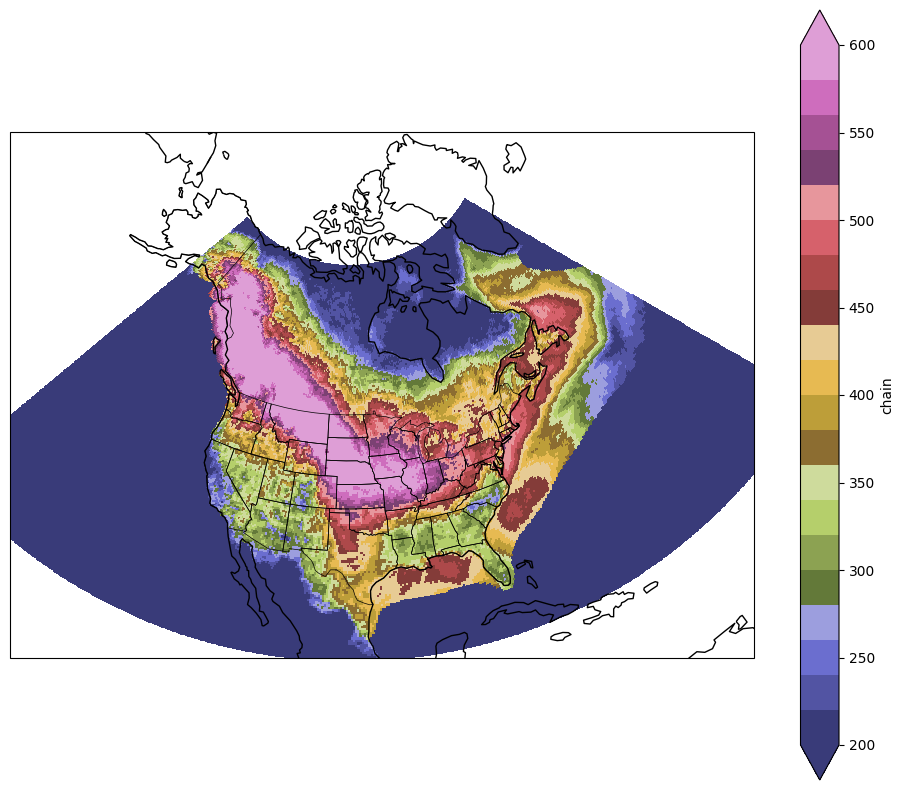

In [25]:
plt.figure(figsize=(12, 10))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
total_cao_days.plot(cmap="tab20b",transform=ccrs.PlateCarree(),vmin=200,vmax=600)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

In [217]:
cao_clusters = clusters_with_chains[clusters_with_chains["chain_id"].isin(valid_chains.chain_id)]

In [218]:
cao_clusters.columns

Index(['label', 'area', 'time', 'cm_lat', 'cm_lon', 'mean', 'stdev', 'median',
       'min_value', 'min_lat', 'min_lon', 'land_fraction', 'chain_id'],
      dtype='object')

In [219]:
cao_clusters.sort_values("cm_lat")

,label,area,time,cm_lat,cm_lon,mean,stdev,median,min_value,min_lat,min_lon,land_fraction,chain_id
3173,1,5.953584e+05,1987-02-15,4,100,-1.940492,0.266905,-1.907639,-2.657357,3,93,0.945437,518
2985,1,8.149017e+05,1984-02-01,6,128,-1.927240,0.275589,-1.895517,-2.889727,1,133,0.960225,476
976,2,7.368051e+05,1955-02-05,7,205,-1.828806,0.234566,-1.790276,-2.785418,4,192,0.892019,153
3356,1,6.013625e+05,1990-02-05,7,99,-1.886085,0.299857,-1.828255,-2.851204,2,57,0.965434,549
2986,1,1.180418e+06,1984-02-02,7,161,-1.955447,0.313319,-1.904358,-2.919106,2,108,0.891952,476
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,15,9.955204e+05,1997-12-14,176,204,-2.378231,0.878342,-2.045635,-6.084460,180,199,0.688889,624
1749,31,6.948912e+05,1966-01-15,176,196,-2.125904,0.432268,-2.066104,-3.933219,181,199,0.994012,286
3812,28,6.883084e+05,1997-12-15,177,187,-2.367011,0.716760,-2.128081,-4.201834,177,178,1.000000,624
1813,33,7.198223e+05,1967-01-10,179,197,-2.393059,0.620340,-2.275969,-4.269861,194,210,0.881044,298


In [89]:
#cao_clusters['area_label'] = cao_clusters.groupby('chain_id')['area'].transform(lambda x: cao_clusters.loc[x.idxmax(), 'label'])
cao_clusters['area_tmin'] = cao_clusters.groupby('chain_id')['area'].transform(lambda x: cao_clusters.loc[x.idxmax(), 'min_value'])
cao_clusters['area_mean'] = cao_clusters.groupby('chain_id')['area'].transform(lambda x: cao_clusters.loc[x.idxmax(), 'mean'])
cao_clusters['time_max_area'] = cao_clusters.groupby('chain_id')['area'].transform(lambda x: cao_clusters.loc[x.idxmax(), 'time'])
cao_clusters['time_min_mean'] = cao_clusters.groupby('chain_id')['mean'].transform(lambda x: cao_clusters.loc[x.idxmin(), 'time'])

C:\Users\ls2236\AppData\Local\Temp\ipykernel_15436\3871812318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cao_clusters['area_tmin'] = cao_clusters.groupby('chain_id')['area'].transform(lambda x: cao_clusters.loc[x.idxmax(), 'min_value'])
C:\Users\ls2236\AppData\Local\Temp\ipykernel_15436\3871812318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cao_clusters['area_mean'] = cao_clusters.groupby('chain_id')['area'].transform(lambda x: cao_clusters.loc[x.idxmax(), 'mean'])
C:\Users\ls2236\AppData\L

In [99]:
cao_summary = cao_clusters.groupby("chain_id").agg(
    
    #{'time': ['min','max'],'area': 'max','min_value': 'min'}
    start = pd.NamedAgg(column="time",aggfunc="min"),
    end = pd.NamedAgg(column="time",aggfunc="max"),
    time_max_area = pd.NamedAgg(column="time_max_area",aggfunc="min"),
    time_min_mean = pd.NamedAgg(column="time_min_mean",aggfunc="min"),
    max_area = pd.NamedAgg(column="area",aggfunc="max"),
    absolut_min_tmean = pd.NamedAgg(column="mean",aggfunc="min"),
    absolut_tmin = pd.NamedAgg(column="min_value",aggfunc="min"),
    max_area_tmin = pd.NamedAgg(column="area_tmin",aggfunc="min"),
    max_area_mean = pd.NamedAgg(column="area_mean",aggfunc="min")
    
    ).reset_index()

In [101]:
cao_summary.sort_values('max_area',ascending=False)

,chain_id,start,end,time_max_area,time_min_mean,max_area,absolut_min_tmean,absolut_tmin,max_area_tmin,max_area_mean
61,118,1951-01-14,1951-02-11,1951-01-31,1951-02-02,1.225020e+07,-2.791006,-5.563636,-4.277880,-2.104710
55,106,1949-12-25,1950-02-11,1950-01-25,1950-02-02,1.169896e+07,-2.777554,-7.156962,-6.160014,-2.115936
101,201,1958-12-30,1959-01-08,1959-01-05,1959-01-04,1.158655e+07,-2.264472,-5.555409,-4.267536,-2.059021
213,431,1979-01-27,1979-02-20,1979-02-10,1979-01-30,1.123119e+07,-2.332192,-5.796785,-4.347478,-1.973107
235,474,1984-01-07,1984-01-22,1984-01-20,1984-01-18,1.068573e+07,-2.224611,-4.555748,-4.124924,-2.084547
...,...,...,...,...,...,...,...,...,...,...
276,542,1989-11-11,1989-11-13,1989-11-12,1989-11-12,8.020031e+05,-1.949174,-3.125516,-3.125516,-1.949174
142,284,1965-03-23,1965-03-25,1965-03-24,1965-03-25,7.556116e+05,-1.965289,-3.350407,-3.350407,-1.870746
369,723,2007-02-28,2007-03-03,2007-03-01,2007-02-28,7.412599e+05,-1.937766,-3.209786,-3.088920,-1.871094
14,26,1942-01-19,1942-01-21,1942-01-20,1942-01-21,7.212578e+05,-2.019783,-3.468679,-3.468679,-1.991685


In [155]:
cao_summary.sort_values('absolut_min_tmean',ascending=False).tail(20)

,chain_id,start,end,time_max_area,time_min_mean,max_area,absolut_min_tmean,absolut_tmin,max_area_tmin,max_area_mean
40,79,1947-01-13,1947-02-11,1947-02-05,1947-01-31,6.701689e+06,-2.594948,-5.558395,-3.873444,-2.049844
159,319,1968-12-21,1969-02-08,1968-12-31,1968-12-29,5.955243e+06,-2.597542,-6.586796,-4.792691,-2.310666
81,156,1955-11-11,1955-11-17,1955-11-16,1955-11-15,2.409152e+06,-2.616782,-6.774499,-4.565799,-2.300403
39,77,1946-12-27,1947-01-08,1947-01-03,1947-01-05,8.382369e+06,-2.634248,-6.658142,-4.977711,-2.071413
50,99,1949-01-15,1949-02-15,1949-01-19,1949-01-30,9.960582e+06,-2.662421,-6.889667,-4.587344,-1.998111
49,98,1949-01-02,1949-01-13,1949-01-04,1949-01-04,3.678659e+06,-2.685456,-6.051080,-6.051080,-2.685456
136,278,1964-12-10,1965-01-19,1965-01-17,1964-12-16,4.555664e+06,-2.688457,-6.770793,-3.753861,-2.112215
258,509,1986-03-08,1986-03-11,1986-03-10,1986-03-10,2.843252e+06,-2.691807,-4.962595,-4.962595,-2.691807
234,473,1983-12-17,1984-01-01,1983-12-25,1983-12-25,9.290744e+06,-2.694080,-5.724709,-4.538039,-2.694080
281,550,1990-02-08,1990-02-22,1990-02-16,1990-02-19,8.918310e+06,-2.695100,-5.318487,-5.056281,-2.024363


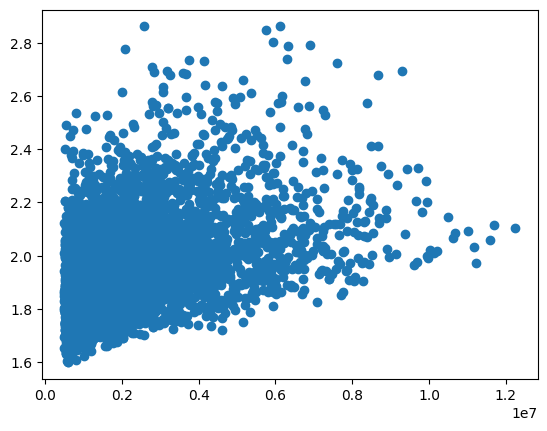

In [ ]:
plt.scatter(cao_clusters['area'],-cao_clusters['min_value'])
plt.scatter(cao_clusters['area'],-cao_clusters['mean'])

<BarContainer object of 57 artists>

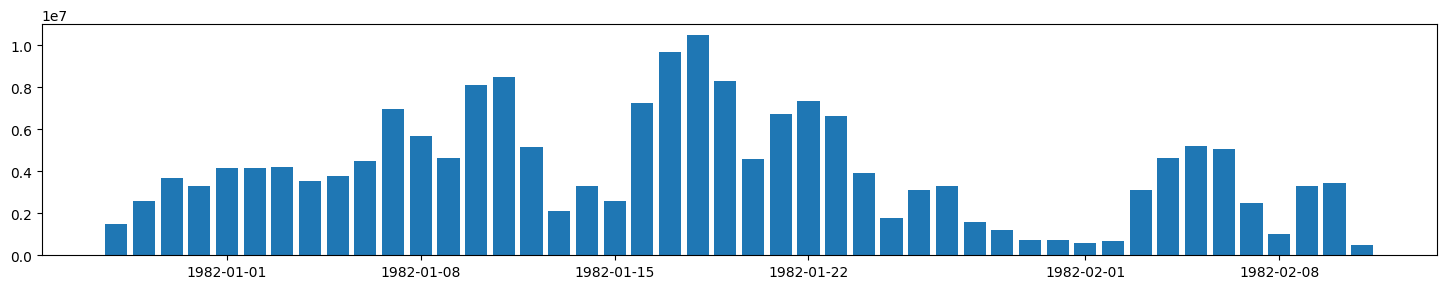

In [130]:
df_plot = clusters_with_chains[clusters_with_chains.chain_id==458]

plt.figure(figsize=(18,3))
plt.bar(df_plot['time'],df_plot['area'])

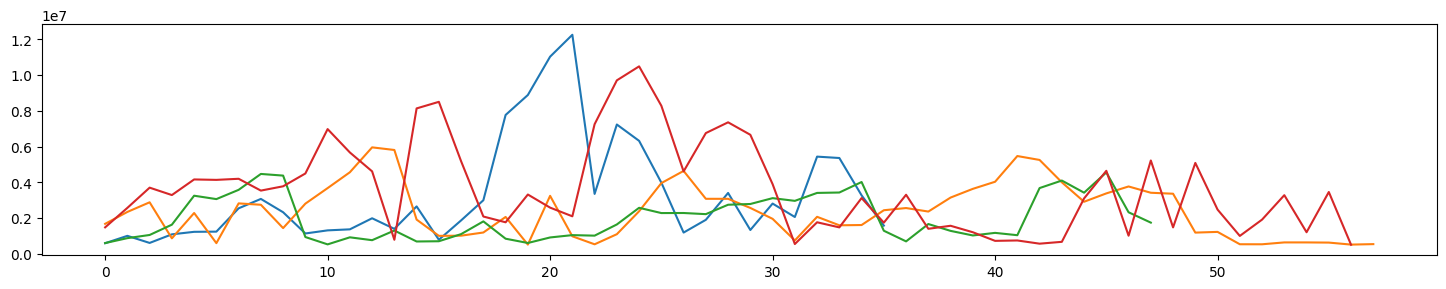

In [120]:

plt.figure(figsize=(18,3))
plt.plot(range(0,len(clusters_with_chains[clusters_with_chains.chain_id==118]['area'])),clusters_with_chains[clusters_with_chains.chain_id==118]['area'])
plt.plot(range(0,len(clusters_with_chains[clusters_with_chains.chain_id==319]['area'])),clusters_with_chains[clusters_with_chains.chain_id==319]['area'])
plt.plot(range(0,len(clusters_with_chains[clusters_with_chains.chain_id==278]['area'])),clusters_with_chains[clusters_with_chains.chain_id==278]['area'])
plt.plot(range(0,len(clusters_with_chains[clusters_with_chains.chain_id==458]['area'])),clusters_with_chains[clusters_with_chains.chain_id==458]['area'])

Text(0.5, 1.0, 'Total extent covered by CAO (km2) by year')

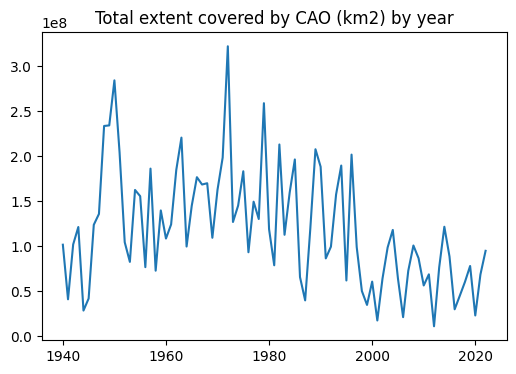

In [170]:
#strongest CAO by year
plt.figure(figsize=(6,4))

plt.plot(cao_clusters.groupby(cao_clusters.time.dt.year)['area'].sum())
plt.title('Total extent covered by CAO (km2) by year')

Text(0.5, 1.0, 'Total extent covered by CAO (km2) by year')

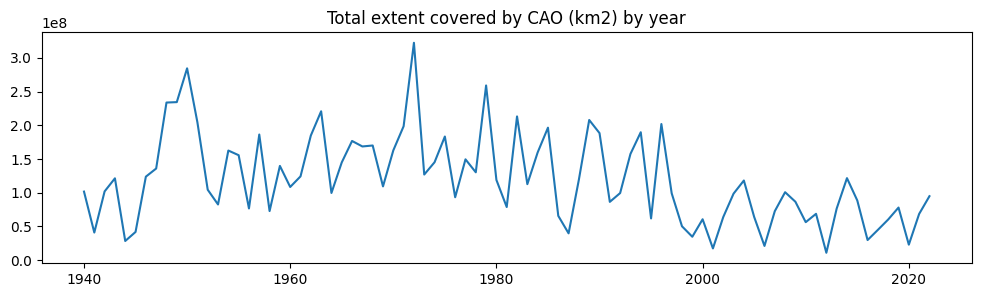

In [171]:
#strongest CAO by year
plt.figure(figsize=(12,3))

plt.plot(cao_clusters.groupby(cao_clusters.time.dt.year)['area'].sum())
plt.title('Total extent covered by CAO (km2) by year')

Text(0.5, 1.0, 'Total extent covered by CAO (km2) by year')

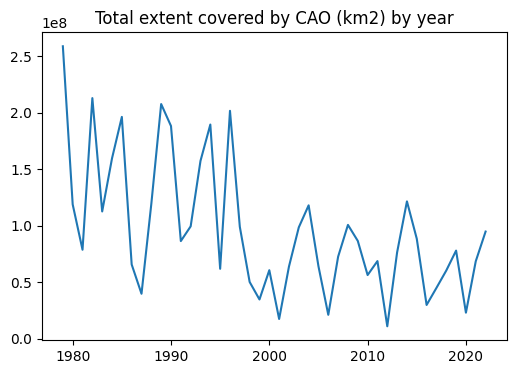

In [172]:
plt.figure(figsize=(6,4))

temp = cao_clusters.groupby(cao_clusters.time.dt.year)['area'].sum().reset_index()
temp = temp[temp.time>=1979]
plt.plot(temp['time'],temp['area'])
plt.title('Total extent covered by CAO (km2) by year')

Text(0.5, 1.0, 'Largest CAO observed in a single day by year')

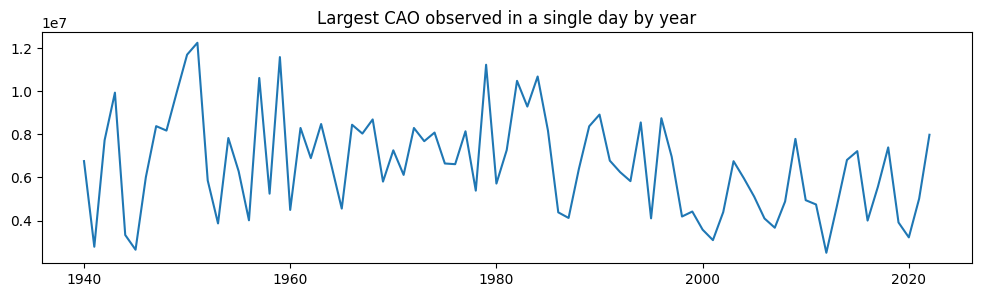

In [143]:
#strongest CAO by year
plt.figure(figsize=(12,3))

plt.plot(cao_clusters.groupby(cao_clusters.time.dt.year)['area'].max())
plt.title('Largest CAO observed in a single day by year')

Text(0.5, 1.0, 'Coldest average CAO')

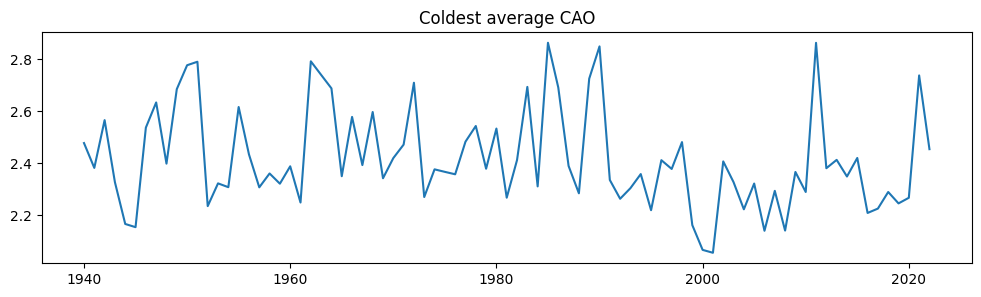

In [146]:
#strongest CAO by year
plt.figure(figsize=(12,3))
plt.plot(-cao_clusters.groupby(cao_clusters.time.dt.year)['mean'].min())
plt.title('Coldest average CAO')

In [156]:
cao_clusters.groupby(cao_clusters.time.dt.year)['mean'].min().reset_index().sort_values('mean').tail(50)

,time,mean
62,2002,-2.407264
8,1948,-2.398682
27,1967,-2.393059
47,1987,-2.389866
20,1960,-2.388413
1,1941,-2.382265
72,2012,-2.381026
39,1979,-2.379057
57,1997,-2.378231
34,1974,-2.376679


Text(0.5, 1.0, 'Lowest temperature')

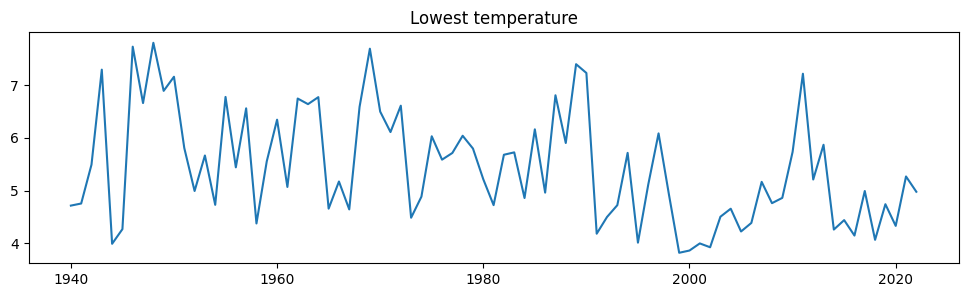

In [147]:
#strongest CAO by year
plt.figure(figsize=(12,3))
plt.plot(-cao_clusters.groupby(cao_clusters.time.dt.year)['min_value'].min())
plt.title('Lowest temperature')

In [148]:
#Specific region
CEUS_lat_min = 30  # degrees N
CEUS_lat_max = 50  # degrees N  
CEUS_lon_min = -110 # degrees W
CEUS_lon_max = -75 # degrees W

In [157]:
CEUS_ds = ds.isel(time=0)

In [160]:
CEUS_mask = (
    (CEUS_ds.latitude >= CEUS_lat_min) & 
    (CEUS_ds.latitude <= CEUS_lat_max) &
    (CEUS_ds.longitude >= CEUS_lon_min) & 
    (CEUS_ds.longitude <= CEUS_lon_max)
)

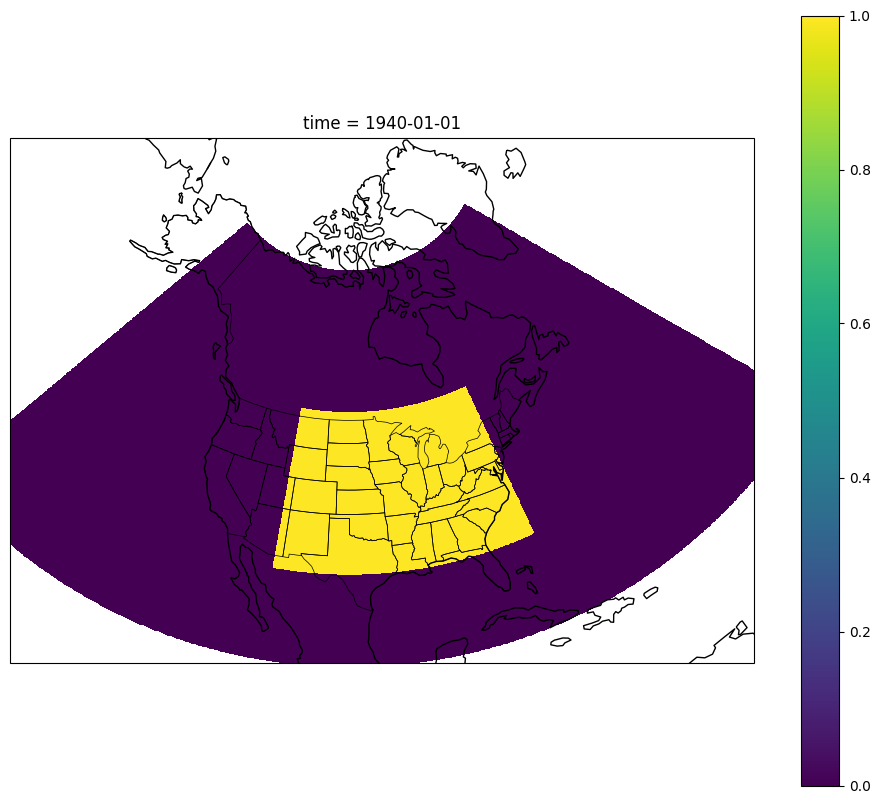

In [ ]:
plt.figure(figsize=(12, 10))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
CEUS_mask.plot(transform=ccrs.PlateCarree())
#total_cao_days.plot(cmap="tab20b",transform=ccrs.PlateCarree(),vmin=200,vmax=600)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

In [176]:
valid_chains.start_date = pd.to_datetime(valid_chains.start_date)


C:\Users\ls2236\AppData\Local\Temp\ipykernel_15436\2249642841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_chains.start_date = pd.to_datetime(valid_chains.start_date)


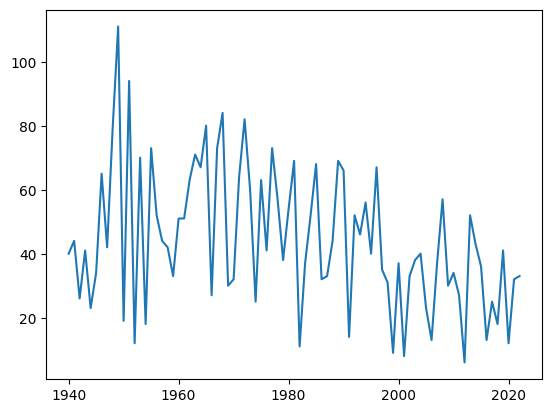

In [185]:
cao_days = valid_chains.groupby(valid_chains.start_date.dt.year)["duration_days"].sum().reset_index()
plt.plot(cao_days.start_date,cao_days.duration_days)

In [186]:
cao_days.sort_values('duration_days')

,start_date,duration_days
72,2012,6
61,2001,8
59,1999,9
42,1982,11
80,2020,12
...,...,...
25,1965,80
32,1972,82
28,1968,84
11,1951,94


In [ ]:
median_area = np.quantile(cao_clusters['area'],q=[0.25])
cao_clusters_filtered = cao_clusters[cao_clusters.area > median_area[0]]
cao_clusters_filtered.groupby(cao_clusters_filtered.time.dt.year)['area'].sum().reset_index()

,time,area
0,1940,9.229201e+07
1,1941,3.142796e+07
2,1942,9.099182e+07
3,1943,1.113022e+08
4,1944,1.759857e+07
...,...,...
78,2018,5.417043e+07
79,2019,7.118597e+07
80,2020,2.126709e+07
81,2021,6.795931e+07


Text(0.5, 1.0, 'CAO days per year (CAO area > P25)')

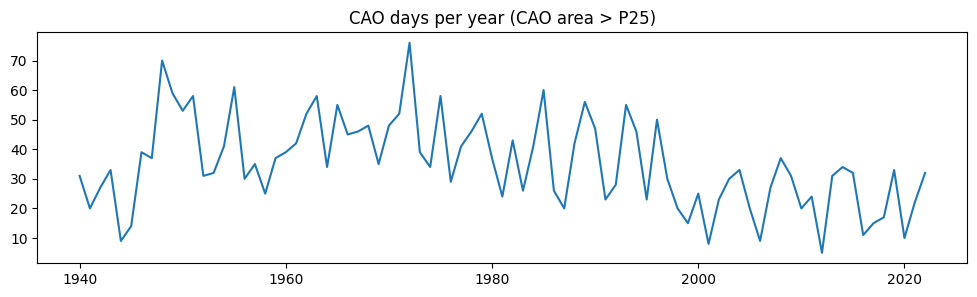

In [215]:
events = cao_clusters_filtered.groupby('time')['label'].count().reset_index()
events = events.groupby(events.time.dt.year)['label'].count().reset_index()
plt.figure(figsize=(12,3))
plt.plot(events.time,events.label)
plt.title('CAO days per year (CAO area > P25)')

Text(0.5, 1.0, 'CAO days per year (all CAO)')

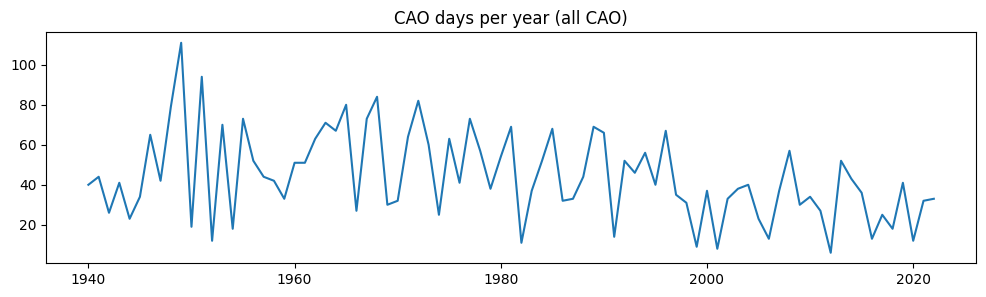

In [214]:
cao_days = valid_chains.groupby(valid_chains.start_date.dt.year)["duration_days"].sum().reset_index()
plt.figure(figsize=(12,3))
plt.plot(cao_days.start_date,cao_days.duration_days)
plt.title('CAO days per year (all CAO)')